# 2.2 Identifying $\delta$ - agcm

We have looked at the contribution from the coupling. What else is important?

A full step by step analysis can be found in the otehr noteboook (bit messy). The main plot however is below:

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

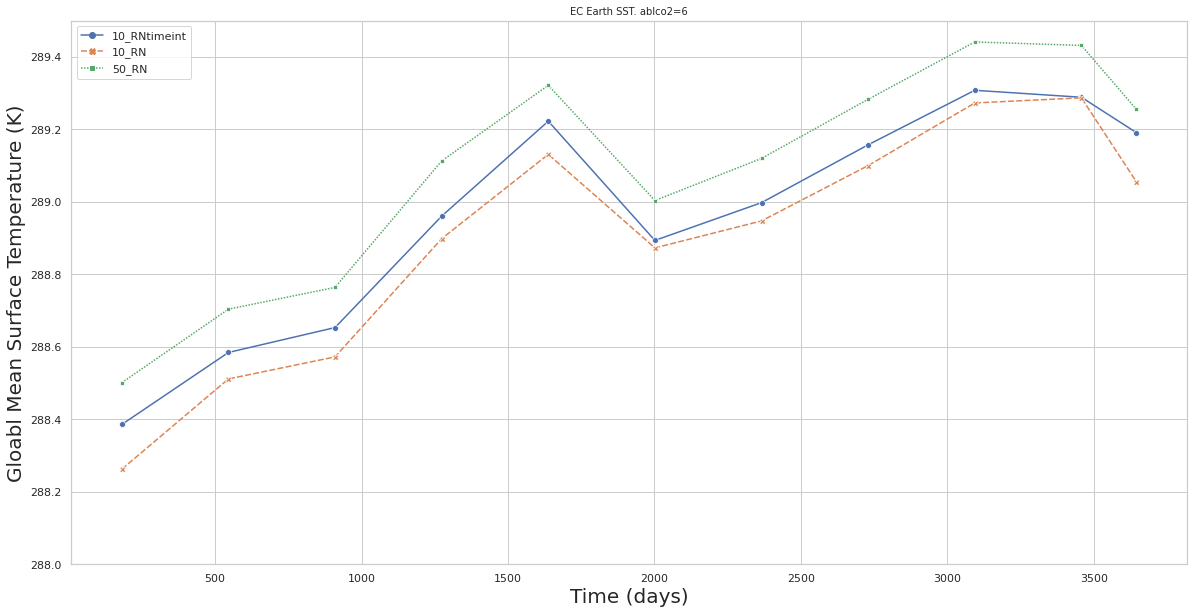

In [1]:
from scripts import *

plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(286.0,288.0),
                   'y': 'temperature'}


import matplotlib as mpl

plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(288.0,289.5),
                   'y': 'temperature'}



backend_ =  mpl.get_backend() 
mpl.use("Agg")  # Prevent showing stuff
#The previous 10 year runs
df_10year_orig = process_and_plot('10yearL2/',plot_kwargs,pd.DataFrame())
#The new run
df_corrected = process_and_plot('ALPHA_10yr/',plot_kwargs,pd.DataFrame())
mpl.use(backend_) # Reset backend

#Bring together
df_all = pd.concat([df_10year_orig,df_corrected])

#Plot
df_selected = df_all.query('precision == "50_RN" | precision == "10_RN" | precision == "10_RNtimeint"' )
plot_means(df_selected,364,plot_kwargs)

This is equivalent to the plot we saw before when considering the coupling. `10_RNtimeint` is the 10bit solution, but with the integration timestep iteself run at high precision. Again a large proportion of the error in the usual 10bit solution seems to come from the integration timestep.



#
#
#
#
#
#
#
#
#
#
#
#
#
#

#
#


















































# Appendix 
----------

First lets grab the 10 and 50 bit solutions from before, along with the low precision coupling soln.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

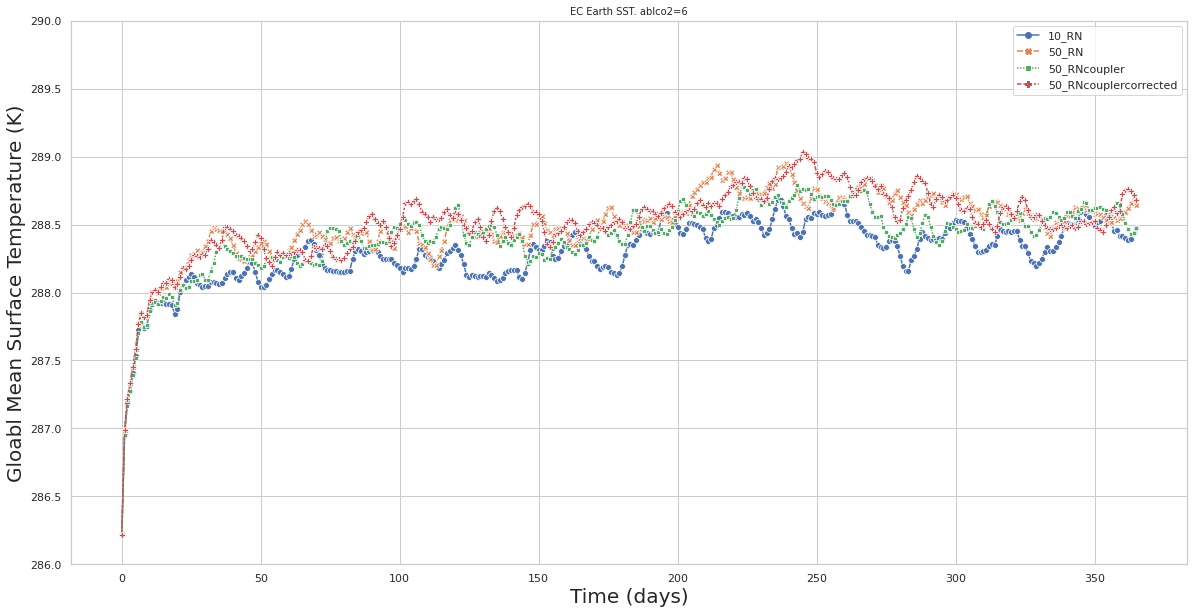

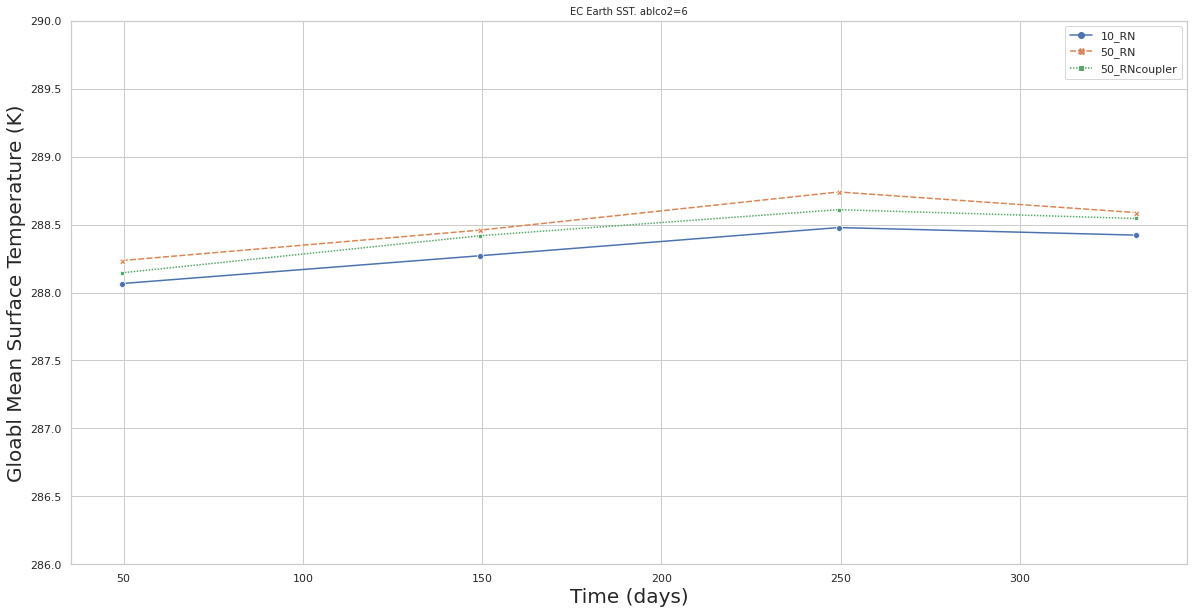

In [2]:
plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(286.0,290.0),
                   'y': 'temperature'}

df_flamingo = process_and_plot('flamingoV2/',plot_kwargs,pd.DataFrame())
df_limits = df_flamingo.query('precision == "50_RN" | precision == "10_RN"| precision == "50_RNcoupler"' )
plot_means(df_limits,100,plot_kwargs)

...and now look at what happens if we run the agcm or the init. at reduced precision **WITH THE COUPLING ALSO AT REDUCED PRECISION**. This should tell us where we are still missing some contribution to $\delta$.

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

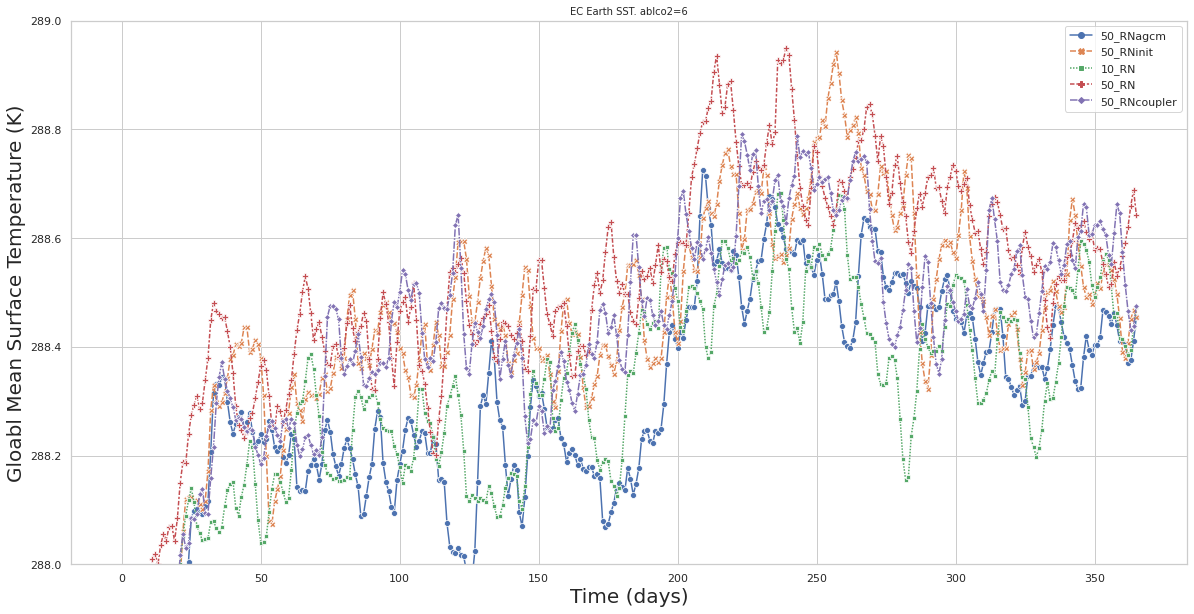

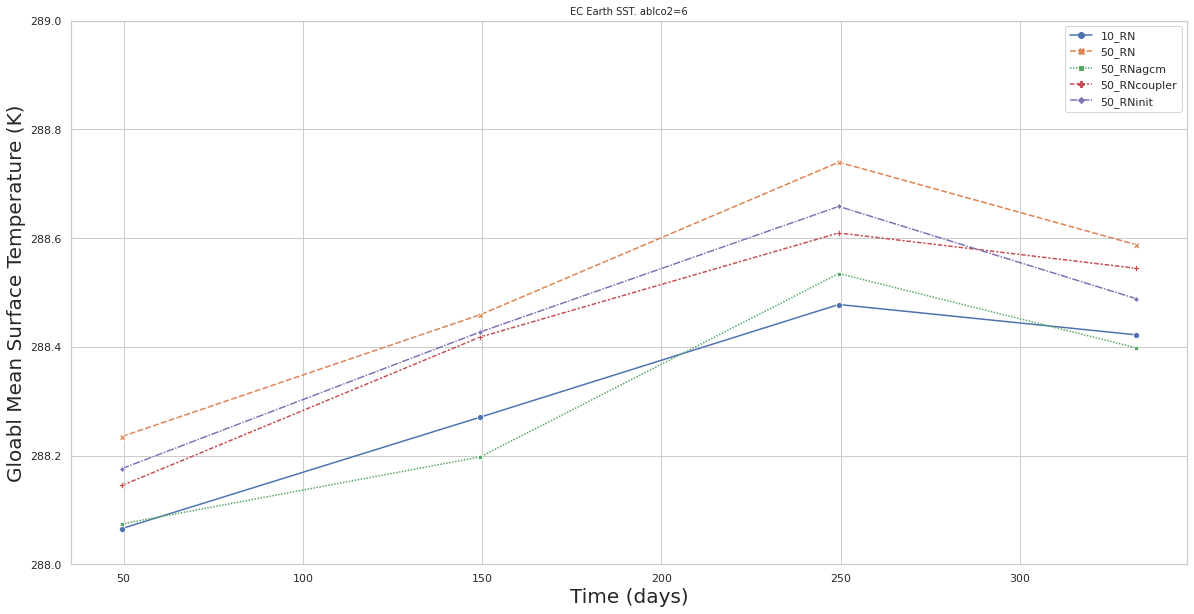

In [3]:



plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(288,289.0),
                   'y': 'temperature'}

df_flamingoV3 = process_and_plot('flamingoV3/',plot_kwargs,df_limits)

plot_means(df_flamingoV3,100,plot_kwargs)

We can see that:
* There is a small/negligible contribution from `init` i.e. it is almost the same as the coupling soln, although there is sime divergence at late times
* there is a large contribution from `RN_agcm` and that this approximates the full low precision solution pretty well.


**This suggests that the rest of the $\delta$ is hiding somewhere in the `agcm` subroutine**

---

# AGCM - Overview

We can now systematically delve into the components of `agcm` to find which are causing this $delta$ shift.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

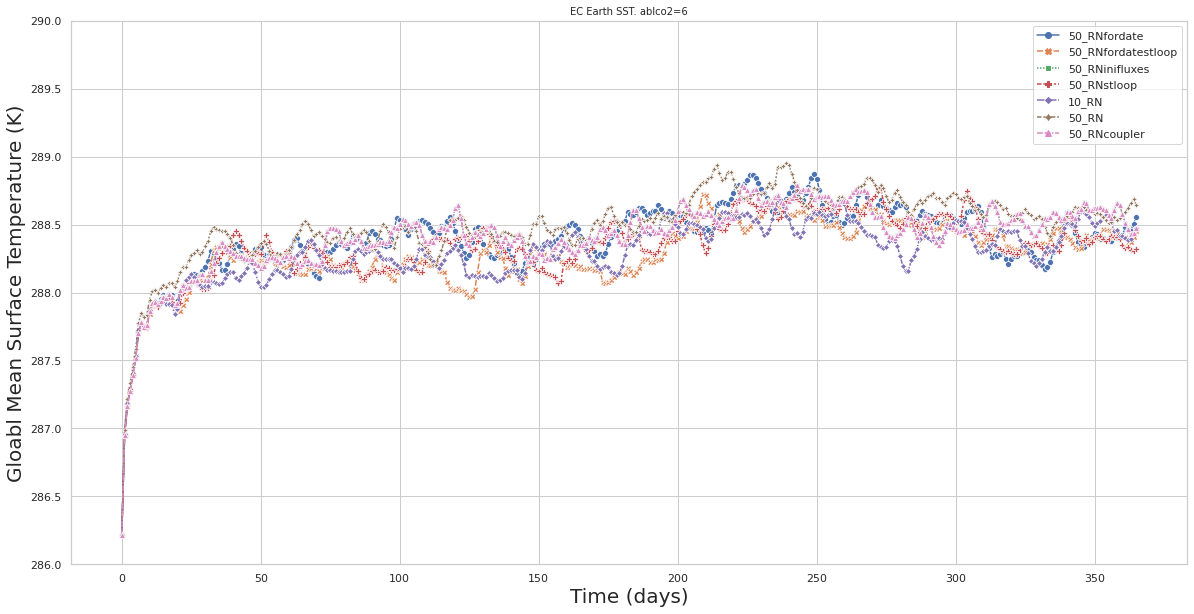

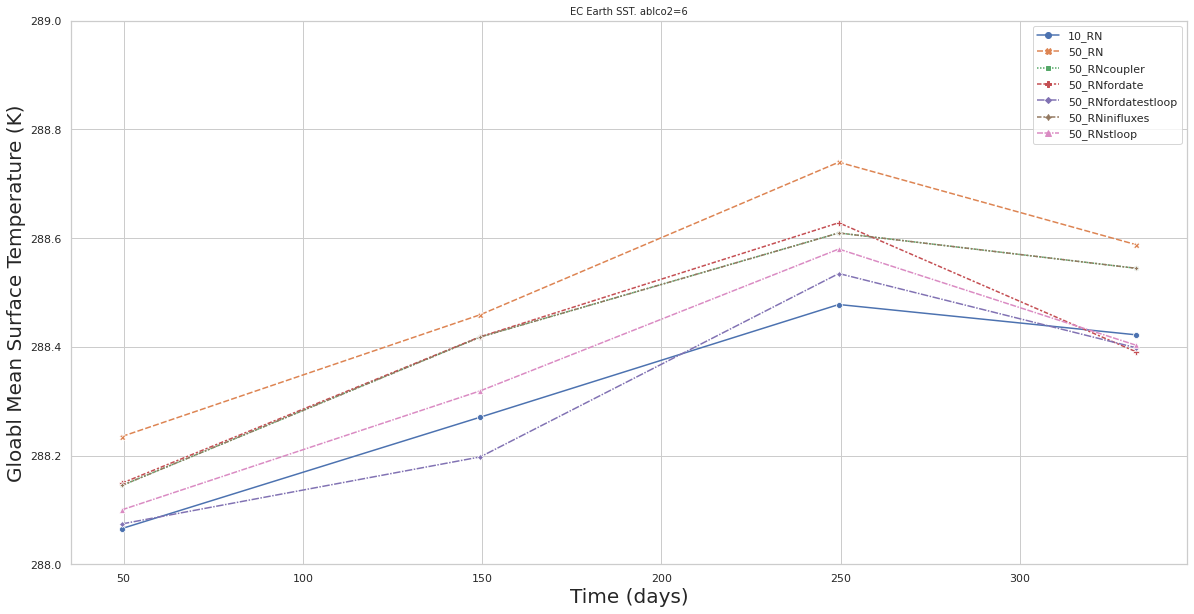

In [4]:

plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(286.0,290.0),
                   'y': 'temperature'}

df_zebra = process_and_plot('zebra/',plot_kwargs,df_limits)


plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(288.0,289.0),
                   'y': 'temperature'}
plot_means(df_zebra,100,plot_kwargs)

Takeaways:
* `Inifluxes` has no effect. 
* `fordate` and `stloop` both have an effect. `stloop` over the whole range and `fordate` at later times Their combined effect (with the coupler also at low precision), is very close to the 10 bit solution.

So now the questions are:
* Q1: which part of stloop?
* Q2: which part of fordate?

---

# Q1 - `stloop` terms

First lets try and look just at `stloop`, for a little overview.

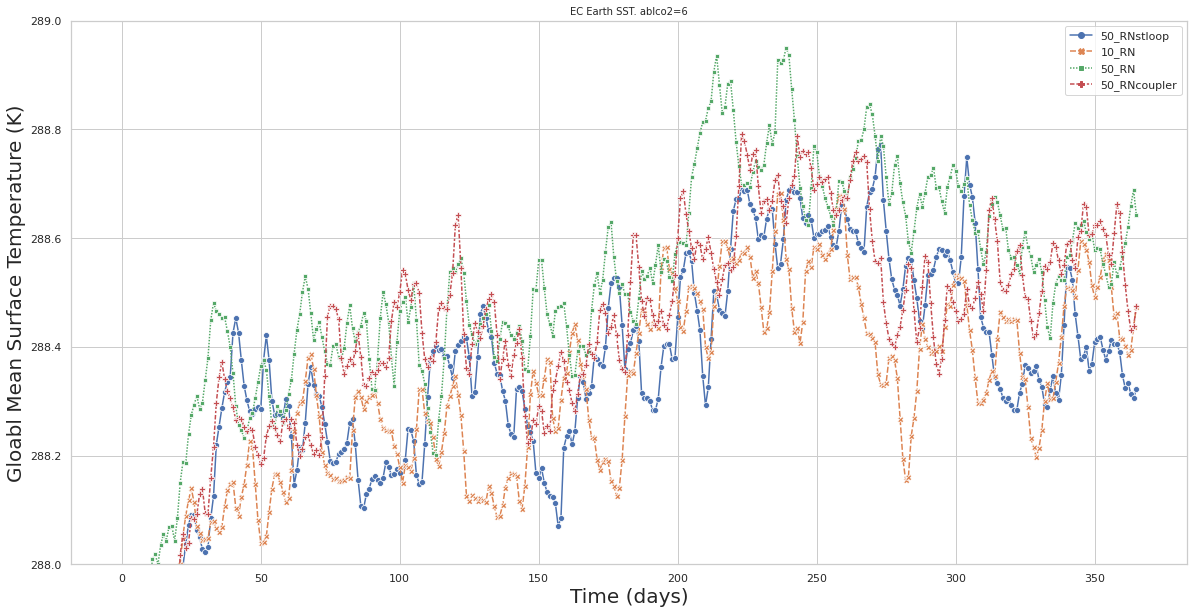

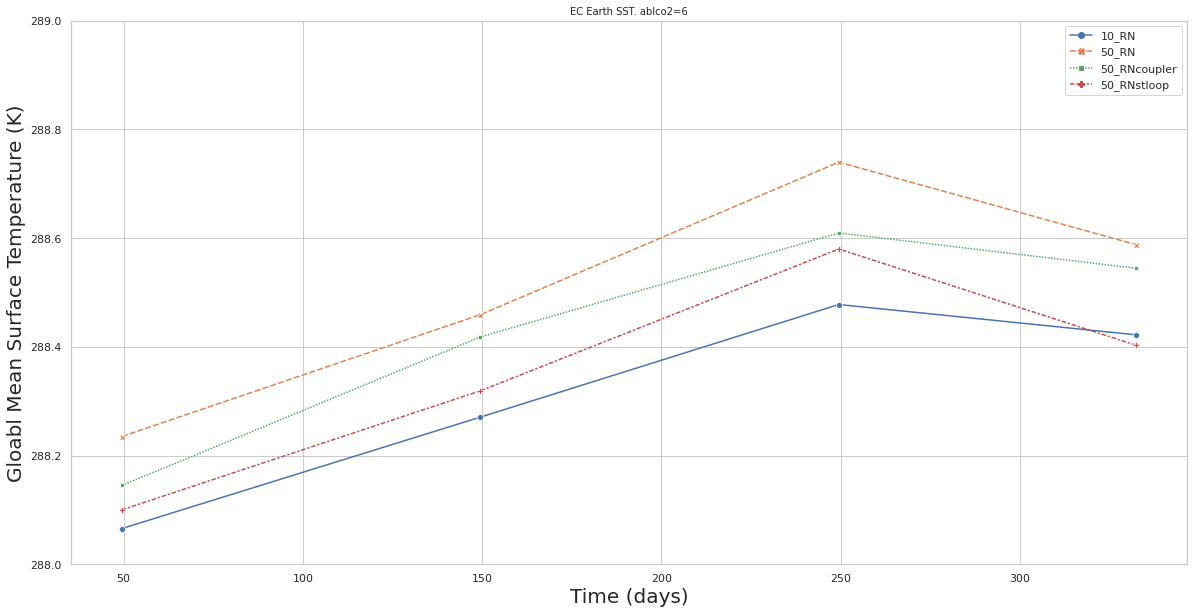

In [29]:
df_zebra_stloop = df_zebra.query('precision == "50_RNstloop"' )
df_zebra_stloop = pd.concat([df_zebra_stloop, df_limits])

plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(288.0,289.0),
                   'y': 'temperature'}


plot_temperature_levels(df_zebra_stloop.reset_index(),fig_title=None,**plot_kwargs)  
plot_means(df_zebra_stloop,100,plot_kwargs)




We can see some extra component in stloop. I.e. when we run everything in high precision EXCEPT `stloop` the solution seems to shift towards the 10 bit solution

---

## Q 1.1 Components of `stloop`

Lets have a look at the parts which make up `stloop`

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

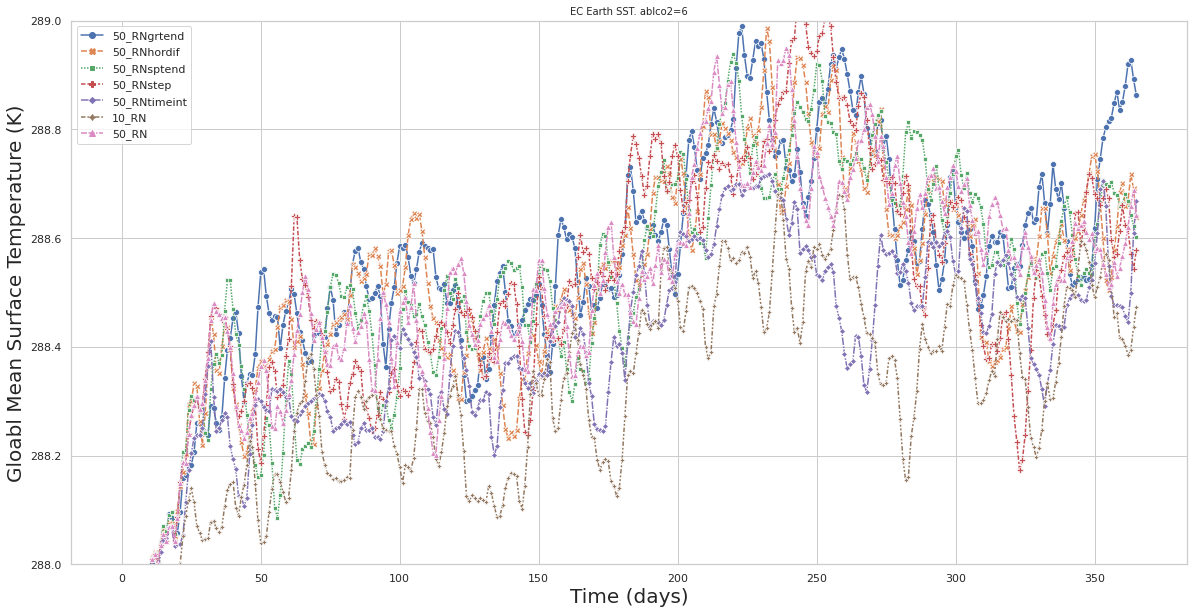

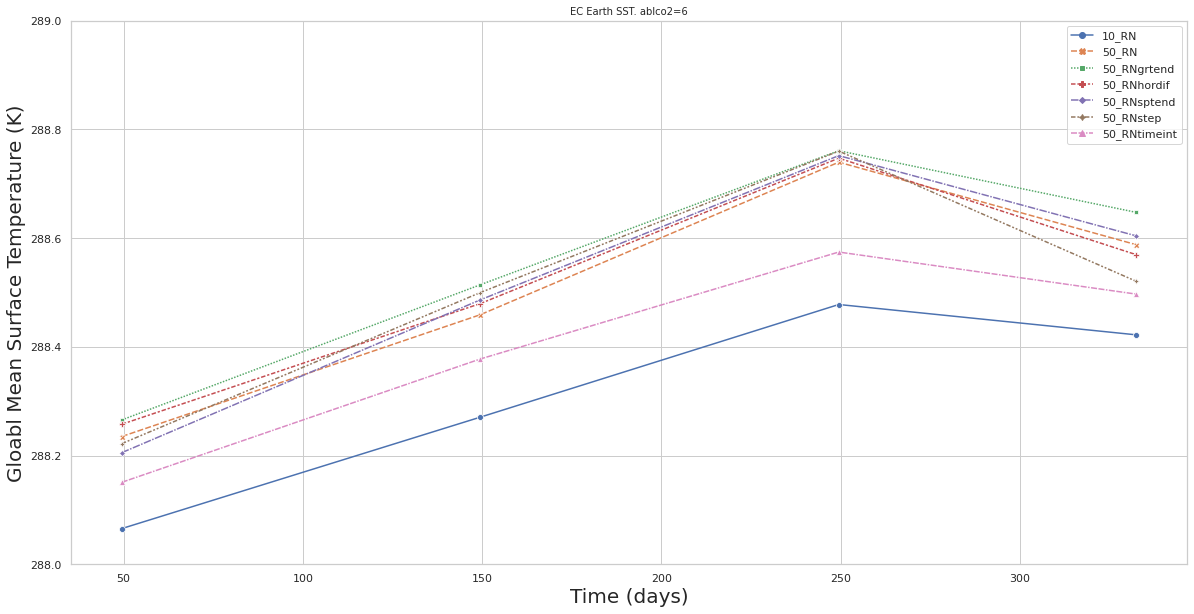

In [31]:
plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(288.0,289.0),
                   'y': 'temperature'}
df_limits = df_flamingo.query('precision == "50_RN" | precision == "10_RN"' )
df_vix2 = process_and_plot('vixenrevisited/',plot_kwargs,df_limits)
plot_means(df_vix2,100,plot_kwargs)

We can see that the dominant contribution is from `timeint`. The part looks like this





```fortran


    ! 4. Time integration with Robert filter
    call set_precision('rp_timeint')
    if (dt<=rpe_literal(0.0_dp)) return

    call apply_truncation(psdt)
    call apply_truncation(vordt)
    call apply_truncation(divdt)
    call apply_truncation(tdt)
    call apply_truncation(trdt)




    if (j1==1) then
        eps = 0.0_dp
    else
        eps = rob
    endif

    call timint(j1,dt,eps,wil,1,ps,psdt,.False.)
    call timint(j1,dt,eps,wil,kx,vor,vordt,.FALSE.)
    call timint(j1,dt,eps,wil,kx,div,divdt,.FALSE.)
    call timint(j1,dt,eps,wil,kx,t,  tdt,.TRUE.)

    do itr=1,ntr
        call timint(j1,dt,eps,wil,kx,tr(:,:,:,1,itr),trdt(:,:,:,itr),.FALSE.)
    enddo

    call set_precision('rp_agcm')

```





Need to clarify if this is from the `timeint` or the `truncation`












We Dominant contributions are time integration (pink) and grtend (green). Note that these could be 'lower' than the umbrella brown since the other components could raise the temperature. Could these factors be two sides of teh same coin? i.e. grtend is imporntant and when we do timeint at low precision we lose the info in grtend anyway?

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

                                  label level    precision  \
0      speedyoneflamingo_L2_10_RN_1year    L2        10_RN   
1      speedyoneflamingo_L2_50_RN_1year    L2        50_RN   
2   speedyonevixen_L2_50_RNgrtend_1year    L2  50_RNgrtend   
3      speedyoneflamingo_L2_10_RN_1year    L2        10_RN   
4      speedyoneflamingo_L2_50_RN_1year    L2        50_RN   
5   speedyonevixen_L2_50_RNgrtend_1year    L2  50_RNgrtend   
6      speedyoneflamingo_L2_10_RN_1year    L2        10_RN   
7      speedyoneflamingo_L2_50_RN_1year    L2        50_RN   
8   speedyonevixen_L2_50_RNgrtend_1year    L2  50_RNgrtend   
9      speedyoneflamingo_L2_10_RN_1year    L2        10_RN   
10     speedyoneflamingo_L2_50_RN_1year    L2        50_RN   
11  speedyonevixen_L2_50_RNgrtend_1year    L2  50_RNgrtend   

                     title  temperature      X  
0   EC Earth SST. ablco2=6   288.065720   49.5  
1   EC Earth SST. ablco2=6   288.235068   49.5  
2   EC Earth SST. ablco2=6   288.153353   49.5

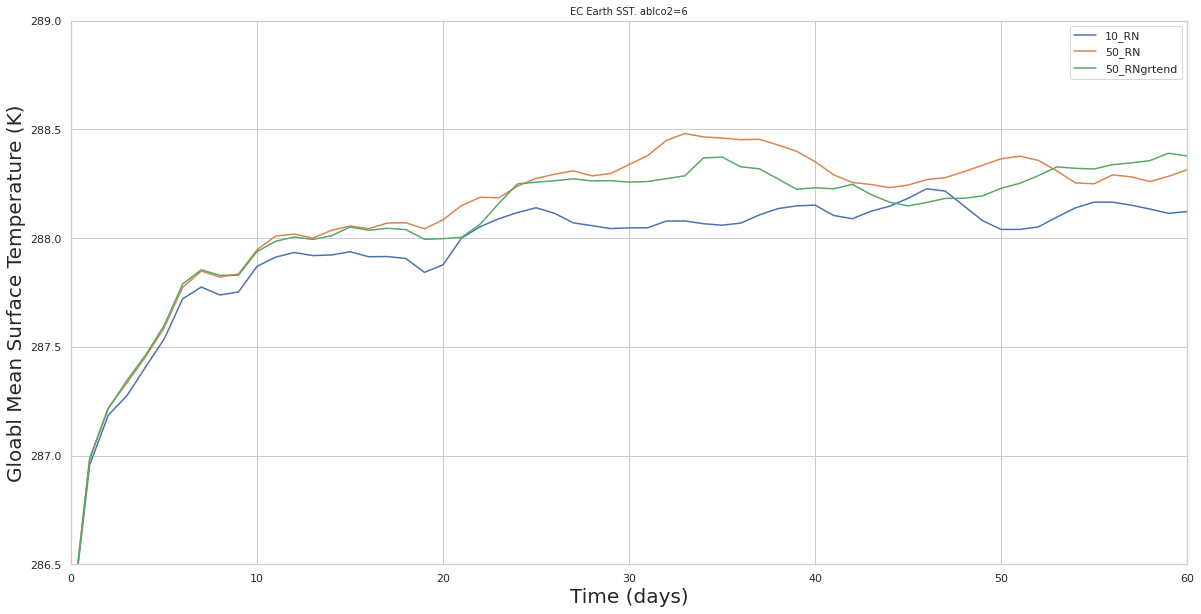

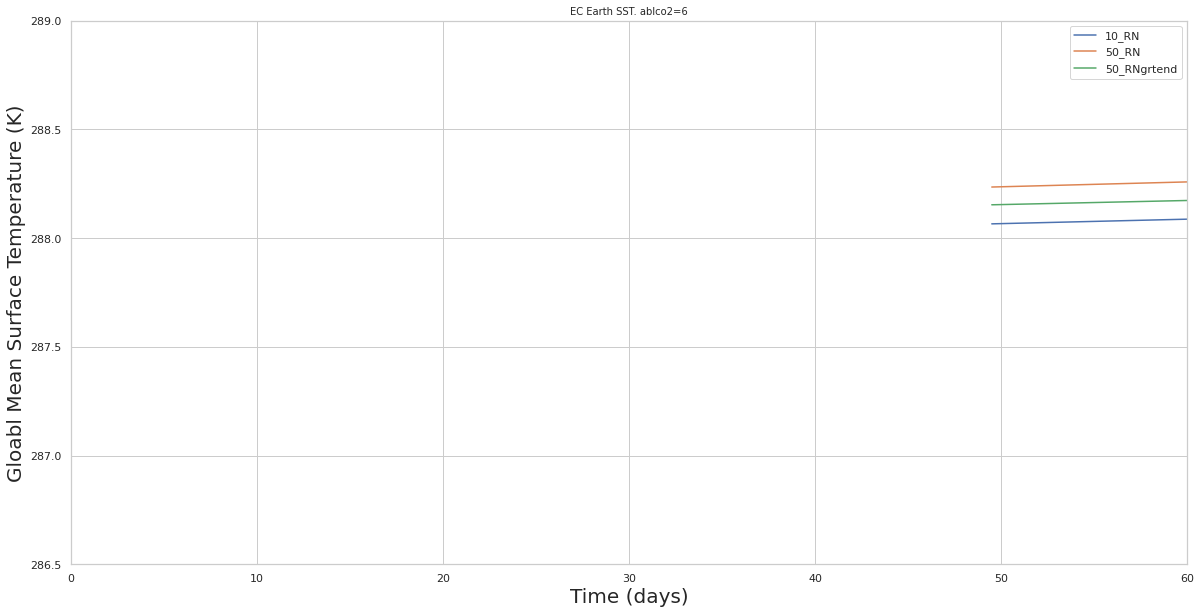

In [238]:
root= '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/vixen/'
df_vixen = process_root_dir(root)


df_stloop = df_combined_sebra.query('precision == "50_RN" | precision == "10_RN"' )





df_combined_vixen = pd.concat([df_stloop, df_vixen.query('precision == "50_RNgrtend"')])





plot_kwargs = {'show_markers': True,
                   'xlimits': (0,60),
                   'ylimits': (286.5,289), 
                   'y': 'temperature'}


plot_temperature_levels(df_combined_vixen,fig_title=None,**plot_kwargs)  







plot_means(df_combined_vixen,100,plot_kwargs)

In [6]:
root= '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/urchin/'
df_vixen = process_root_dir(root)


df_stloop = df_combined_sebra.query('precision == "50_RN" | precision == "10_RN"' )





df_combined_vixen = pd.concat([df_stloop, df_vixen])





plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                   'ylimits': (286.5,289), 
                   'y': 'temperature'}


plot_temperature_levels(df_combined_vixen,fig_title=None,**plot_kwargs)  







plot_means(df_combined_vixen,100,plot_kwargs)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

NameError: name 'df_combined_sebra' is not defined

# 4.1.2 - fordate terms

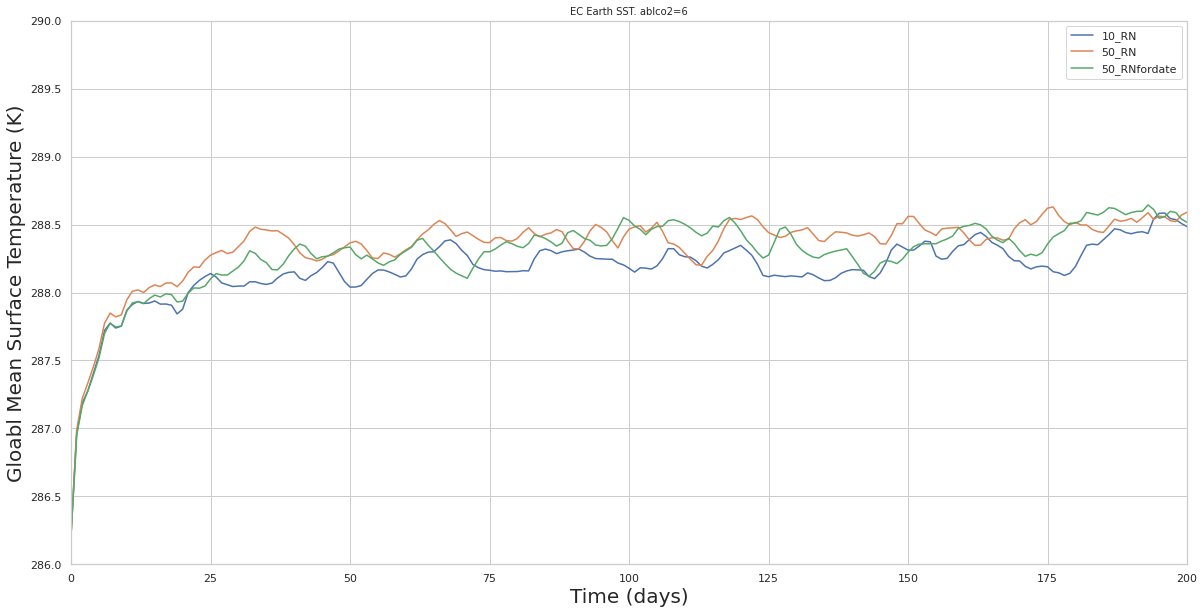

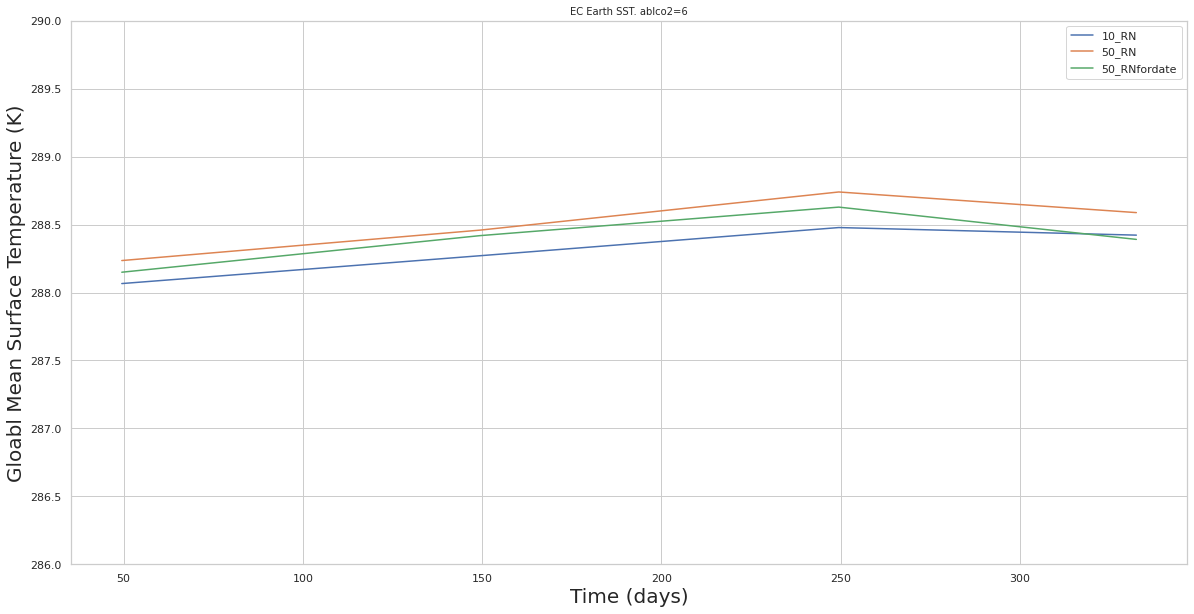

In [219]:
df_stloop = df_combined_sebra.query('precision == "50_RN" | precision == "10_RN" | precision == "50_RNfordate"' )

plot_kwargs = {'show_markers': True,
                   'xlimits': (0,200),
                   'y': 'temperature'}


plot_temperature_levels(df_stloop,fig_title=None,**plot_kwargs)  


plot_means(df_stloop,100)





-------------------------------

# 4.2 Identifying $\delta$ - agcm_1_day

Ok so how do our various solutions peform if we ensure that the Climatological fields are always at 50bit?
